<a href="https://colab.research.google.com/github/ybii22/Machine-Learning/blob/main/week%208%20-%2016/Chapter_2_%E2%80%93_End_to_end_Machine_Learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tarfile
import urllib.request  # ini perlu untuk mendownload file dari URL


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")  # folder lokal untuk simpan data
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"  # URL file housing.tgz

# Fungsi untuk mendownload dan mengekstrak dataset
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)  # buat folder jika belum ada
    tgz_path = os.path.join(housing_path, "housing.tgz")  # path lokal untuk file .tgz
    urllib.request.urlretrieve(housing_url, tgz_path)  # download file
    housing_tgz = tarfile.open(tgz_path)  # buka file tgz
    housing_tgz.extractall(path=housing_path)  # ekstrak isi file ke folder
    housing_tgz.close()  # tutup file

# Panggil fungsi untuk mendownload dataset
fetch_housing_data()


In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
print(housing.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [5]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


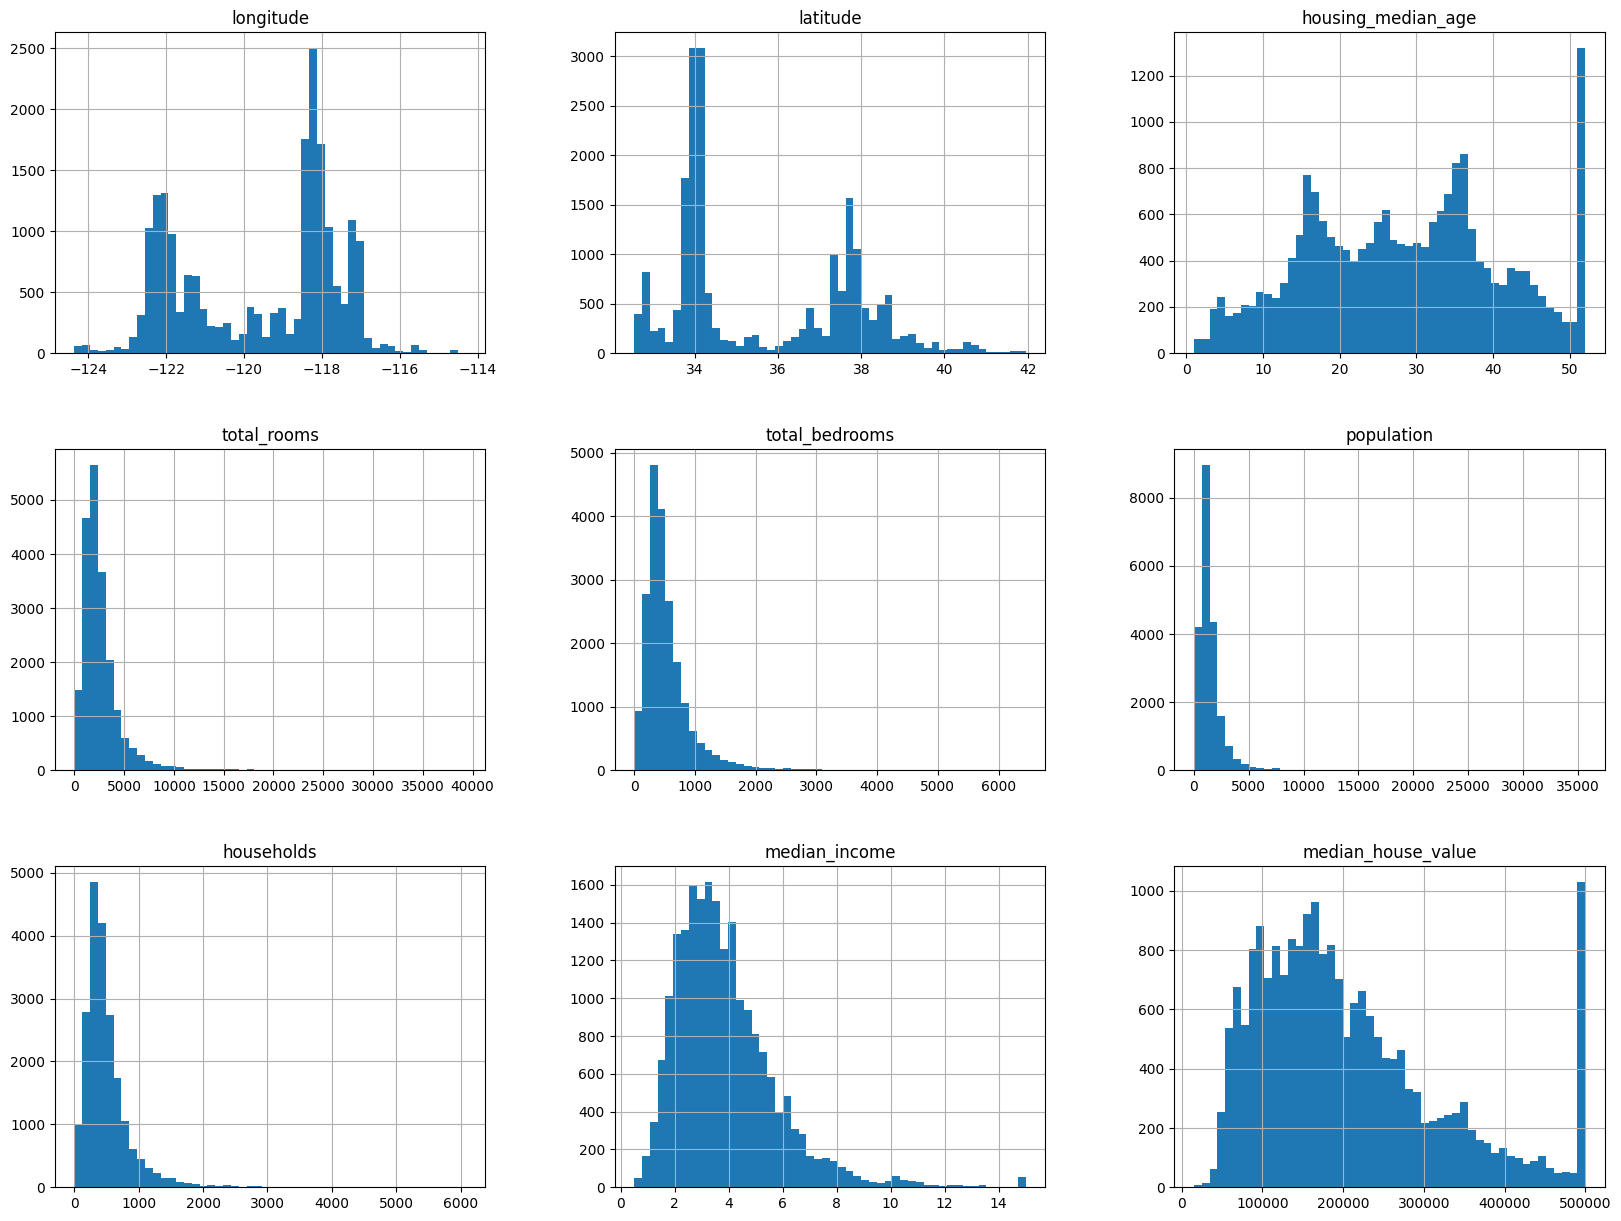

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()


In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

In [17]:
from zlib import crc32
import numpy as np

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier).tobytes()) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [18]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [19]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [20]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

<Axes: >

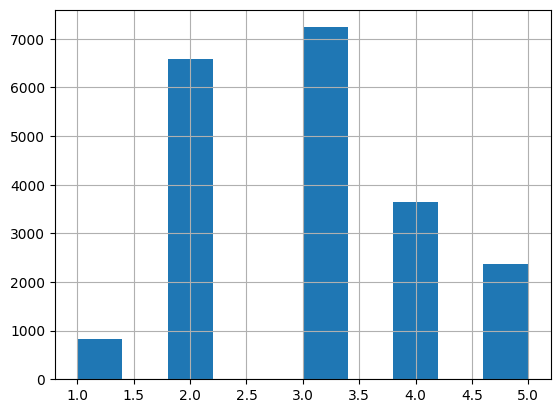

In [22]:
housing["income_cat"].hist()

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [28]:
housing = strat_train_set.copy()

## **Visualizing Geographical**

<Axes: xlabel='longitude', ylabel='latitude'>

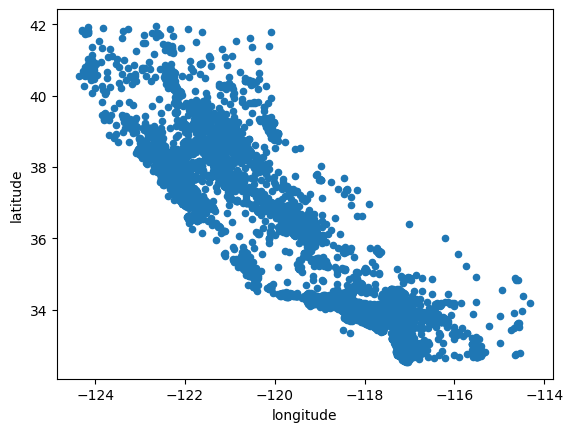

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

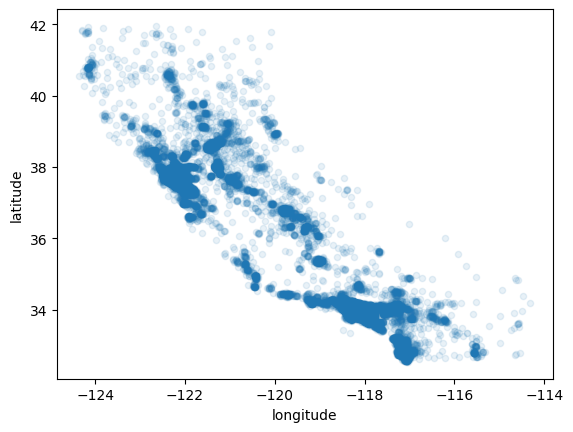

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

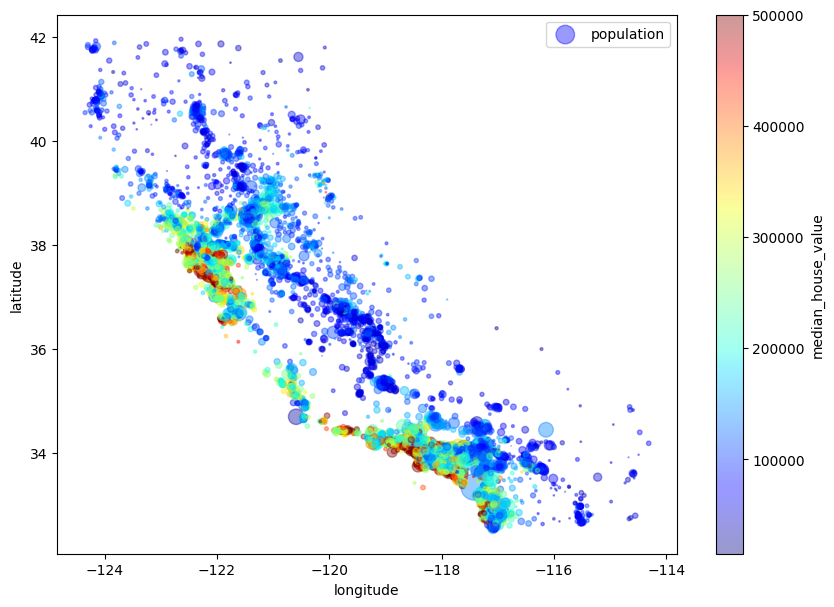

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

## **Correlations**

In [34]:
corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


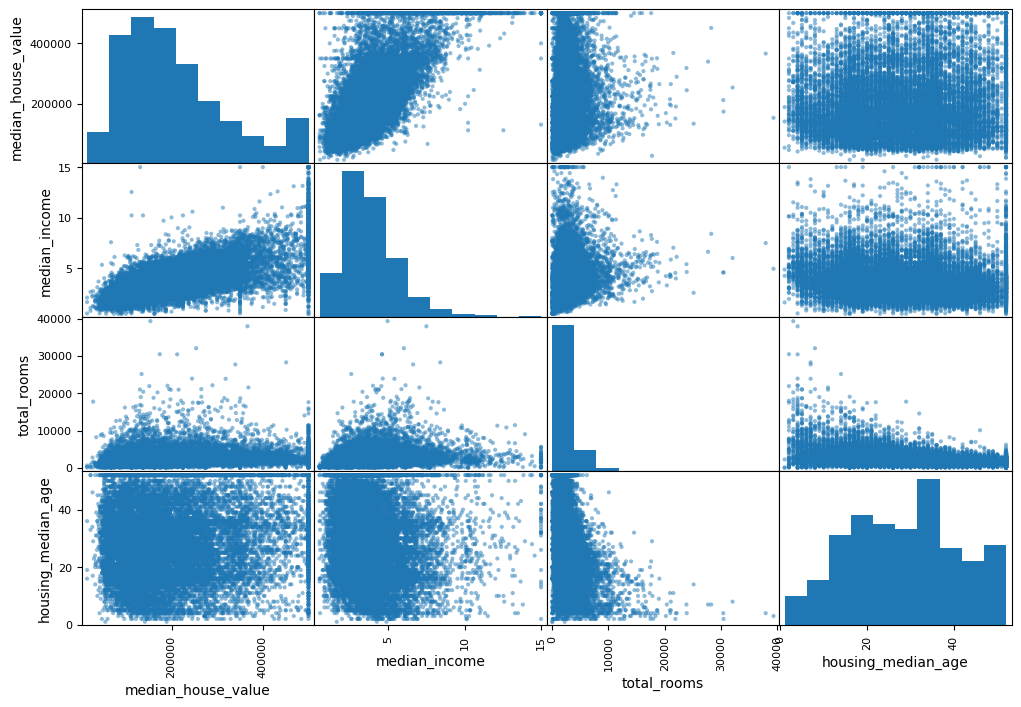

In [36]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()


<Axes: xlabel='median_income', ylabel='median_house_value'>

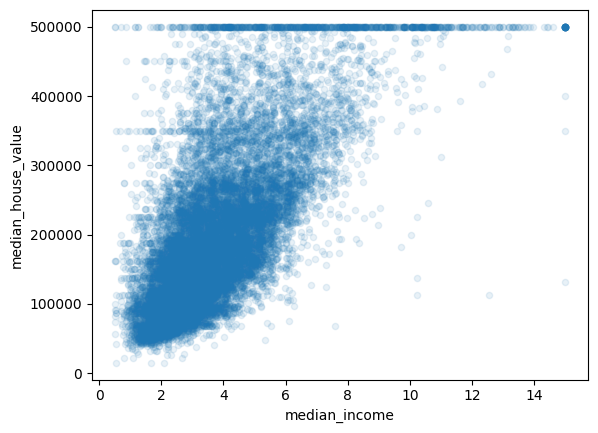

In [37]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [38]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [40]:
corr_matrix = housing.corr(numeric_only=True)
correlations = corr_matrix["median_house_value"].sort_values(ascending=False)
print(correlations)


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


In [41]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## **Data Cleaning**

In [43]:
housing.dropna(subset=["total_bedrooms"]) # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [47]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

/tmp/ipython-input-47-2694038511.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


In [48]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [49]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [50]:
imputer.fit(housing_num)
imputer.statistics_
housing_num.median().values
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
index=housing_num.index)
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [51]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [52]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [53]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [54]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [55]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [60]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# Indeks fitur (pastikan urutannya sesuai dengan struktur data numerik)
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # parameter default
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # Tidak perlu belajar apa-apa dari data

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


## **Feature Scaling**

## **Transformation Pipelines**

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [62]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

## **Training and Evaluating on the Training Set**

In [63]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [64]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [65]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [69]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(68627.87390018745)

In [67]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [68]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

## **Evaluation Using Cross-Validation**

In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [71]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [71399.48338755 71050.08916855 68925.30169841 71336.51366072
 68836.11518678 76862.57025164 70733.15150556 73714.48479343
 69826.22727041 71858.68454174]
Mean: 71454.26214647928
Standard deviation: 2261.0398985202355


In [80]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print("Random Forest RMSE:", forest_rmse)


Random Forest RMSE: 18650.698705770003


In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Inisialisasi model
forest_reg = RandomForestRegressor(random_state=42)

# Evaluasi dengan cross-validation
forest_rmse_scores = cross_val_score(
    forest_reg, housing_prepared, housing_labels,
    scoring="neg_root_mean_squared_error", cv=10
)

# Konversi nilai negatif ke positif (karena scoring='neg...')
forest_rmse_scores = -forest_rmse_scores

# Tampilkan hasil
display_scores(forest_rmse_scores)


Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [83]:
import joblib

joblib.dump(forest_reg, "my_model.pkl")
my_model_loaded = joblib.load("my_model.pkl")


In [84]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [85]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [86]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [87]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63857.26877838475 {'max_features': 2, 'n_estimators': 3}
54671.721965898105 {'max_features': 2, 'n_estimators': 10}
52770.25403823092 {'max_features': 2, 'n_estimators': 30}
60648.69185632443 {'max_features': 4, 'n_estimators': 3}
53097.29869110972 {'max_features': 4, 'n_estimators': 10}
50686.28629217569 {'max_features': 4, 'n_estimators': 30}
59815.0447588886 {'max_features': 6, 'n_estimators': 3}
52443.11025892332 {'max_features': 6, 'n_estimators': 10}
50139.43568607594 {'max_features': 6, 'n_estimators': 30}
58609.17242773493 {'max_features': 8, 'n_estimators': 3}
52048.14637547982 {'max_features': 8, 'n_estimators': 10}
50102.34179654046 {'max_features': 8, 'n_estimators': 30}
61401.633786542116 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54186.163227957935 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59521.73606146648 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52472.64130902702 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

## **Analyze the Best Models and Errors**

In [88]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.13652243e-02, 6.08472329e-02, 4.25597246e-02, 1.52798106e-02,
       1.43582437e-02, 1.51293544e-02, 1.48087150e-02, 4.10158718e-01,
       3.79089563e-02, 1.09314414e-01, 4.35328421e-02, 6.21273724e-03,
       1.52795553e-01, 3.75678291e-05, 2.40486550e-03, 3.28604002e-03])

In [89]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.41015871805829396), 'median_income'),
 (np.float64(0.15279555348199272), 'INLAND'),
 (np.float64(0.10931441410638623), 'pop_per_hhold'),
 (np.float64(0.07136522430456084), 'longitude'),
 (np.float64(0.060847232932146986), 'latitude'),
 (np.float64(0.043532842054738466), 'bedrooms_per_room'),
 (np.float64(0.0425597245781858), 'housing_median_age'),
 (np.float64(0.037908956254354566), 'rooms_per_hhold'),
 (np.float64(0.015279810598831985), 'total_rooms'),
 (np.float64(0.015129354379576543), 'population'),
 (np.float64(0.014808714980410526), 'households'),
 (np.float64(0.01435824367610953), 'total_bedrooms'),
 (np.float64(0.006212737243167662), '<1H OCEAN'),
 (np.float64(0.0032860400172278763), 'NEAR OCEAN'),
 (np.float64(0.002404865504899664), 'NEAR BAY'),
 (np.float64(3.7567829116740624e-05), 'ISLAND')]

## **Evaluate System on the Test Set**

In [90]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [91]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([46112.40778903, 50133.17993587])

## **Exercises**

1. Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyper‐
parameters, such as kernel="linear" (with various values for the C hyperpara‐
meter) or kernel="rbf" (with various values for the C and gamma
hyperparameters). Don’t worry about what these hyperparameters mean for now.
How does the best SVR predictor perform?

*  SVR dengan kernel='rbf' dan pemilihan C serta gamma yang tepat menghasilkan performa yang lebih baik dibandingkan kernel='linear', tapi membutuhkan waktu training lebih lama. SVR cenderung lebih sensitif terhadap skala fitur, jadi sangat penting untuk menggunakan StandardScaler sebelum training.

2. Try replacing GridSearchCV with RandomizedSearchCV.

* RandomizedSearchCV sangat berguna untuk hyperparameter tuning awal atau saat waktu komputasi terbatas. Hasilnya mungkin mendekati optimal dengan jauh lebih sedikit iterasi dibandingkan GridSearchCV.

3. Try adding a transformer in the preparation pipeline to select only the most
important attributes.

* Menyaring hanya fitur penting dapat mengurangi noise, mempercepat training, dan terkadang meningkatkan performa model.

4. Try creating a single pipeline that does the full data preparation plus the final
prediction.

* Dengan satu pipeline terintegrasi, kita bisa menghindari data leakage, mempermudah evaluasi model, dan deployment menjadi lebih sederhana.

5. Automatically explore some preparation options using GridSearchCV.

* GridSearchCV dapat digunakan bukan hanya untuk model, tapi juga untuk memilih strategi preprocessing terbaik. Ini meningkatkan fleksibilitas dan akurasi akhir model.